In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from Utils import *

In [2]:
random_state = 0

# Load data

In [3]:
train_directory = 'CleanData/train_numerical.csv'
test_directory = 'CleanData/group_validation.csv'

In [4]:
train_data = pd.read_csv(train_directory)
test_data = pd.read_csv(test_directory)
train_data.head(5)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,3,2492,3,6.811316e+10,4,1,275.0
1,3,2492,3,6.053890e+10,4,1,276.0
2,3,2349,3,7.993668e+10,1,8,2.0
3,3,2349,3,6.053880e+10,1,7,1001.0
4,3,2381,3,7.993666e+10,1,7,1749.0


In [5]:
features = ['Weekday', 'ScanCount', 'DepartmentDescription', 'FinelineNumber', 'Upc']
train = train_data[features].values
train_label = train_data.TripType.values
test = test_data[features].values
test_label = test_data.TripType.values
n_classes = np.unique(test_label)
cv_train = np.vstack([train,test])
cv_label = np.hstack([train_label, test_label])
del train_data
del test_data

## Data Overview

In [6]:
np.unique(train_label, return_counts=True)

(array([  3,   4,   5,   6,   7,   8,   9,  14,  15,  18,  19,  20,  21,
         22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
         35,  36,  37,  38,  39,  40,  41,  42,  43,  44, 999]),
 array([ 297,   30,  279,   80,  455,  526,  377,    8,  143,  114,   33,
          67,  129,   64,   11,  437,  468,  117,  191,   36,   20,   78,
          26,  164,  210,   55,  246,  366,  511,  542, 1586, 3131,  105,
         324,  160,  225,  348]))

In [7]:
print(train.shape)
print(test.shape)

(11959, 5)
(4998, 5)


# Training

In [8]:
classifier = svm.SVC(kernel='rbf', decision_function_shape='ovr')

In [9]:
classifier.fit(train, train_label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [10]:
train_accuracy = classifier.score(train, train_label)
testing_accuracy = classifier.score(test, test_label)
print('Training accuracy =', train_accuracy)
print("Testing accuracy =", testing_accuracy)

Training accuracy = 0.773643281211
Testing accuracy = 0.279711884754


## Cross Validation

In [11]:
combine_train = np.vstack([train, test])
combine_label = np.hstack([train_label, test_label])

In [12]:
cv_result = crossValidation(combine_train, combine_label, classifier, 3)

In [13]:
print("The result for each fold is \n", cv_result)
print("The average result is ", cv_result.mean())

The result for each fold is 
 [[ 0.28556263]
 [ 0.29210899]
 [ 0.28940386]]
The average result is  0.289025159008


## Stratified Cross Validation

In [14]:
scv_result = scv(combine_train, combine_label, classifier, cv = 3)
print("The result for each fold is \n", scv_result)
print("The average result is ", scv_result.mean())

The result for each fold is 
 [[ 0.28281637]
 [ 0.28163699]
 [ 0.29060031]]
The average result is  0.285017887329


# Grid Search on C and gamma

In [15]:
c_options = [0.01, 0.05, 0.1, 0.5 , 1, 10]
gamma_options = [1/5, 1/2, 1]
num_options = len(c_options)
numer_of_cv = 5
search_result = np.zeros([num_options*3, numer_of_cv])

In [ ]:
for i in range(num_options):
    for j in range(3):
        clf = svm.SVC(C = c_options[i], gamma=gamma_options[j], kernel='rbf', decision_function_shape='ovr')
        values = crossValidation(combine_train, combine_label, clf, numer_of_cv)
        values = np.ravel(values)
        search_result[i, :] = values
        print('Running on combo c=%0.2f, gamma=%0.2f, mean = %f' % 
              ( c_options[i], gamma_options[j], values.mean()))

Running on combo c=0.01, gamma=0.20, mean = 0.267735
Running on combo c=0.01, gamma=0.50, mean = 0.267735
Running on combo c=0.01, gamma=1.00, mean = 0.267736
Running on combo c=0.05, gamma=0.20, mean = 0.280061
Running on combo c=0.05, gamma=0.50, mean = 0.279590
Running on combo c=0.05, gamma=1.00, mean = 0.277231
Running on combo c=0.10, gamma=0.20, mean = 0.284485
Running on combo c=0.10, gamma=0.50, mean = 0.282949
Running on combo c=0.10, gamma=1.00, mean = 0.279827
Running on combo c=0.50, gamma=0.20, mean = 0.292328
Running on combo c=0.50, gamma=0.50, mean = 0.290264
Running on combo c=0.50, gamma=1.00, mean = 0.287020
Running on combo c=1.00, gamma=0.20, mean = 0.284779
Running on combo c=1.00, gamma=0.50, mean = 0.283422
Running on combo c=1.00, gamma=1.00, mean = 0.281182
Running on combo c=10.00, gamma=0.20, mean = 0.271746
Running on combo c=10.00, gamma=0.50, mean = 0.270272


In [ ]:
opt = np.argmax(search_result.mean(axis = 1))
opt_c = int(np.floor(float(opt)/num_options))
opt_gamma = opt % num_options
print('The best result is obtained with C  = %0.2f, gamma = %0.2f, mean = %0.2f, std = %f' % 
        (c_options[opt_c], gamma_options[opt_gamma], search_result[opt,:].mean(), search_result[opt,:].std()))

## Confusion Matrix

In [58]:
confusion_mat = confusion_matrix(pred, test_label, np.unique(train_label).tolist())
confusion = pd.DataFrame(confusion_mat)
confusion.columns = np.unique(train_label)
confusion.head(8)

,3,4,5,6,7,8,9,15,18,19,...,36,37,38,39,40,41,42,43,44,999
0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,14.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,6.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,28.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,83.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,10.0,19.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,1.0,53.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,0.0,0.0,...,0.0,0.0,1.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0


## Micro ROC Curve

In [67]:
y_score = classifier.decision_function(test)
lb = LabelBinarizer()
new_test_label = lb.fit(train_label).transform(test_label)
fpr, tpr = roc_curve(new_test_label.ravel(), y_score.ravel())

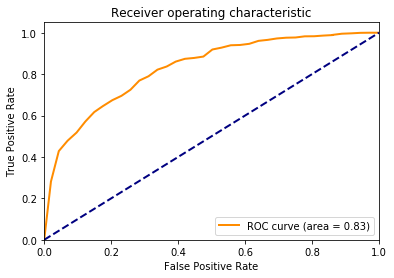

In [68]:
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()